# Policy sweep plotting (minimal)

Goal: Load epoch-level aggregates and produce per-learning-rate plots for a chosen policy class.
- X axis: epoch
- Y axis: mean reward (per-epoch average across trajectories)
- One trace per (policy_class, run_id) within each learning-rate facet

This cleaned-up notebook imports small helpers and focuses on the end result: per-learning-rate plots.

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from utils.plot_utils import (
    load_epoch_agg_multi,
    filter_epoch_df,
    extract_fields,
    plot_epoch_rewards,
    last_epoch_table,
)

In [2]:
# Inputs (keep minimal)
# One or more result directories (directory passed to --output-dir when running experiments)
DATA_DIRS = [
    "results/grid_sweep_top/parquet",
]

# Note:
# Remaining options are now passed inline to the helper functions in later cells
# to reduce global state and make chaining explicit.

In [3]:
# Load all epoch aggregate parquet files from one or more directories

df = load_epoch_agg_multi(DATA_DIRS)
if df.empty:
    print(f"No parquet files found under: {DATA_DIRS}")
else:
    display(df.head())
    print('Rows:', len(df))

,run_id,config_hash,label,setup,num_days,num_trajs,num_epochs,epoch,agent_name,policy_class,policy_params_json,mean_reward,std_reward,n_trajs,source_dir
0,17ceb0f2-2845-48af-9974-660b07b77c8f,a4e21ce2e05786adf1ae350487544265a3d0fd2e042dc0...,grid_sweep_top-i18,setup_1,1,200,3000,0,agent1,AC_TD_Gaussian_v3_MarketEnv_Continuous,"{""auction_item_spec_ids"": [2], ""budget_per_rea...",0.241132,4.973467,200,results/grid_sweep_top/parquet
1,17ceb0f2-2845-48af-9974-660b07b77c8f,a4e21ce2e05786adf1ae350487544265a3d0fd2e042dc0...,grid_sweep_top-i18,setup_1,1,200,3000,0,agent2,FixedBidPolicy,"{""bid_per_item"": 5, ""total_limit"": 5}",0.000000,0.000000,200,results/grid_sweep_top/parquet
2,17ceb0f2-2845-48af-9974-660b07b77c8f,a4e21ce2e05786adf1ae350487544265a3d0fd2e042dc0...,grid_sweep_top-i18,setup_1,1,200,3000,1,agent1,AC_TD_Gaussian_v3_MarketEnv_Continuous,"{""auction_item_spec_ids"": [2], ""budget_per_rea...",0.346203,4.510103,200,results/grid_sweep_top/parquet
3,17ceb0f2-2845-48af-9974-660b07b77c8f,a4e21ce2e05786adf1ae350487544265a3d0fd2e042dc0...,grid_sweep_top-i18,setup_1,1,200,3000,1,agent2,FixedBidPolicy,"{""bid_per_item"": 5, ""total_limit"": 5}",0.000000,0.000000,200,results/grid_sweep_top/parquet
4,17ceb0f2-2845-48af-9974-660b07b77c8f,a4e21ce2e05786adf1ae350487544265a3d0fd2e042dc0...,grid_sweep_top-i18,setup_1,1,200,3000,2,agent1,AC_TD_Gaussian_v3_MarketEnv_Continuous,"{""auction_item_spec_ids"": [2], ""budget_per_rea...",1.355987,4.517697,200,results/grid_sweep_top/parquet


Rows: 156000


Setup: setup_1 | Agent: agent1 | Label prefix: None
Learning rates found: [5e-07, 5e-06]


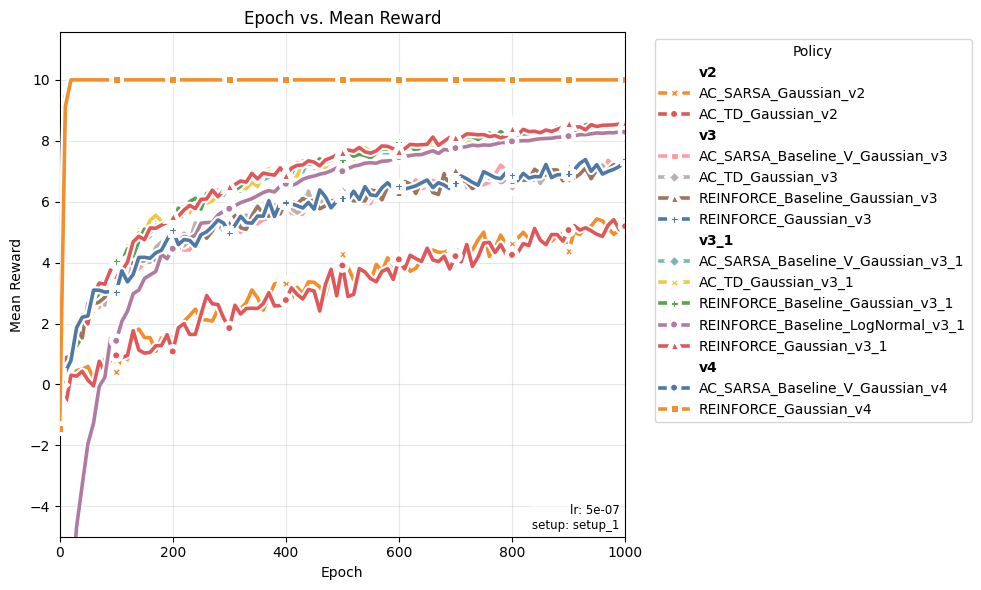

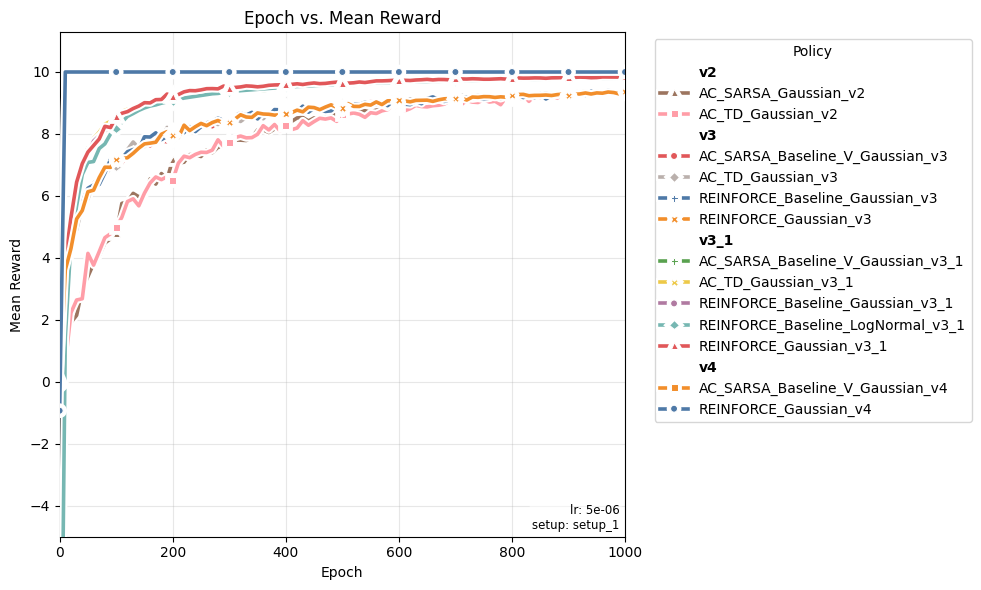

In [8]:
# Extract learning_rate into its own column and plot, grouped by learning rate (all policies)
setup = "setup_1"           # e.g., 'setup_1'
agent_name = "agent1"      # e.g., 'agent1'
label = None           # e.g., 'grid_sweep_top' (prefix match)

# Extract the learning_rate field into its own column
filtered = extract_fields(
    df,
    nested_column="policy_params_json",
    fields="learning_rate",
    new_column_name="learning_rate",
)

# Apply filters (setup/agent exact), and label as a prefix filter
base = filter_epoch_df(filtered, setup=setup, agent_name=agent_name, label=None)
if label is not None and 'label' in base.columns:
    base = base[base['label'].astype(str).str.startswith(label, na=False)]

# List the unique learning rates present after filtering
vals = sorted(v for v in base['learning_rate'].unique() if pd.notna(v))
print('Setup:', setup, '| Agent:', agent_name, '| Label prefix:', label)
print('Learning rates found:', vals)

# Plot one figure per learning rate (all policies included in each plot)
for lr in vals:
    sub = base[base['learning_rate'] == lr]
    if sub.empty:
        print("Warning: No data for learning_rate =", lr)
        continue
    fig, ax = plot_epoch_rewards(
        sub,
        title="Epoch vs. Mean Reward",
        x_min=0,
        x_max=1000,
        y_min=-5,
        plot_every_epoch=10,
        top_k=13,
        top_k_markers=True,
        top_k_marker_size=5,
        top_k_marker_every_epoch=100,
        outline_width=3.0,
        top_k_linestyles=('-', '-', '-'),
        palette='tab10',
        # Group legend entries by version extracted from policy names (e.g., v2, v3_1, v4) and place groups side-by-side
        legend_group_regex=r"(v\d+(?:_\d+)?)",
        legend_group_side_by_side=False,
        legend_position="right",
        # legend_group_side_by_side=True,
        # legend_position="bottom",
        # Minimal metadata box (opt-in): show learning rate and setup
        show_metadata=True,
        metadata_keys=("learning_rate", "setup"),
        metadata_loc='bottom-right',
        metadata_fontsize=8.5,
        metadata_box_alpha=0.5,
    )
    display(fig)
    plt.close(fig)

In [5]:
# Build a sorted table of last-epoch mean rewards per (policy_class, run_id) and include policy_params_json
from utils.plot_utils import last_epoch_table

if 'base' in globals() and not base.empty:
    table = last_epoch_table(
        base,
        group_cols=("policy_class", "run_id"),
        epoch_col="epoch",
        value_col="mean_reward",
        sort_desc=True,
        extra_cols=("policy_params_json",),
    )
    display(table)
else:
    print("No data in 'base' to summarize.")

,policy_class,run_id,last_epoch_mean_reward,last_epoch,policy_params_json
0,AC_SARSA_Baseline_V_Gaussian_v4_MarketEnv_Cont...,c3f23eea-214f-4604-8820-708070a6ff82,9.999624,2999,"{""auction_item_spec_ids"": [2], ""budget_per_rea..."
1,REINFORCE_Gaussian_v4_MarketEnv_Continuous,5d3e642d-99fd-4e70-a432-867339f7aefe,9.999595,2999,"{""auction_item_spec_ids"": [2], ""budget_per_rea..."
2,AC_SARSA_Baseline_V_Gaussian_v4_MarketEnv_Cont...,2eac9d82-da74-4c85-84fa-8f90b5a9d1ee,9.999593,2999,"{""auction_item_spec_ids"": [2], ""budget_per_rea..."
3,REINFORCE_Gaussian_v4_MarketEnv_Continuous,f1e6c286-1f80-42df-9b52-f950e65cdf82,9.999579,2999,"{""auction_item_spec_ids"": [2], ""budget_per_rea..."
4,REINFORCE_Gaussian_v3_1_MarketEnv_Continuous,f6fa16ba-7e63-4b74-bd89-dedddd235c4f,9.943951,2999,"{""auction_item_spec_ids"": [2], ""budget_per_rea..."
5,REINFORCE_Baseline_LogNormal_v3_1_MarketEnv_Co...,b8de8859-0946-4114-b565-9f699f0d37ad,9.933310,2999,"{""auction_item_spec_ids"": [2], ""budget_per_rea..."
6,AC_SARSA_Baseline_V_Gaussian_v3_1_MarketEnv_Co...,f06bb6f7-61dd-4c42-870d-83783e4c6864,9.927954,2999,"{""auction_item_spec_ids"": [2], ""budget_per_rea..."
7,AC_TD_Gaussian_v3_1_MarketEnv_Continuous,693a7797-354c-464f-b9aa-c63a4c014735,9.921969,2999,"{""auction_item_spec_ids"": [2], ""budget_per_rea..."
8,REINFORCE_Baseline_Gaussian_v3_1_MarketEnv_Con...,7aa3e8c1-0418-4e39-b880-04c246f13ce8,9.911839,2999,"{""auction_item_spec_ids"": [2], ""budget_per_rea..."
9,AC_TD_Gaussian_v2_MarketEnv_Continuous,e5eb03b6-3f91-46a6-855f-caa41cd08b36,9.820866,2999,"{""auction_item_spec_ids"": [2], ""budget_per_rea..."
